# Домашнее задание 1. Сбор данных

*** Автор --- Ракитин Виталий, BD-11 ***

При решении реальных задач мы почти никогда не имеем дело с "хорошими" исходными данными, уже подготовленными для обработки и анализа. Как правило на входе имеются неструкткрированные данные в "грязном" виде, например необработанные тексты, изображения или аудио файлы. Иногда нет даже этого, и данные приходится собирать из разных доступных источников: разнообразных баз данных, внешних сервисов и даже электронных таблиц. После того, как данные получены, их унифицируют, очищают от шума, преобразовывают в нужный вид и сохраняют для дальнейшего анализа. В одном из традиционных подходов к [Data Mining](http://www.wikiwand.com/en/Online_analytical_processing) этот процесс называется Extract-Transform-Load ([ETL](http://www.wikiwand.com/en/Extract,_transform,_load)).

Цель этого задания собрать первые данные о пользователях из обучающей выборки и провести простейший качественный анализ. В ходе решения будут использованы:
1. [numpy](http://www.numpy.org/) -- библиотека для работы с многомерными массивами
2. [pandas](http://pandas.pydata.org/) -- библиотека, позволяющая удобно работать с различными типами данных
3. [requests](http://docs.python-requests.org/en/latest/) -- библиотека, которую можно использовать для вызова HTTP запросов
4. [python-twitter](https://github.com/bear/python-twitter/tree/master/twitter) -- обертка для Twitter API
5. [matplotlib](http://matplotlib.org/) -- библиотека для рисования графиков в python

Первым делом импортируем необходимые библиотеки и убеждаемся, что все установлено.

In [2]:
import pandas as pd
import numpy as np
import pylab as pl
import mpl_toolkits.basemap as bm
import twitter
import requests
import datetime
import dateutil
import csv
import os
import json

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Чтение исходных данных из файла

Считываем исходные данные из файла в data frame библиотеки pandas. Полученный data frame должен иметь целочисленный ключ и две колонки:
1. uid -- идентификатор пользователя
2. cat -- числовой номер класса

In [4]:
TRAINING_SET_PATH = "train.csv"
TESTING_SET_PATH = "test.csv"
df_users_train = pd.read_csv(TRAINING_SET_PATH, sep=",", header=0)
df_users_ex = pd.read_csv(TESTING_SET_PATH, sep=",", header=0)
df_users_ex['cls'] = None
df_users = pd.concat([df_users_train, df_users_ex])
df_users.head()

,uid,cls
0,202388889,1.0
1,1392518336,0.0
2,361208576,1.0
3,1535215357,1.0
4,4396196375,1.0


Построим распределение целевой переменной. Требуется получить [barchart](http://www.wikiwand.com/en/Bar_chart), в котором высота столбика, соответствующего каждому из классов, пропорциональна количеству пользователей этого класса. По горизонтальной оси отложены классы (positive, negative), а по вертикальной -- количество пользователей.

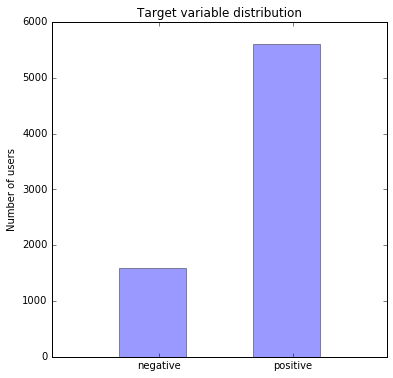

In [5]:
# Compute the distribution of the target variable
counts, bins = np.histogram(df_users_train["cls"], bins=[0,1,2])

# Plot the distribution
pl.figure(figsize=(6,6))
pl.bar(bins[:-1], counts, width=0.5, alpha=0.4)
pl.xticks(bins[:-1] + 0.3, ["negative", "positive"])
pl.xlim(bins[0] - 0.5, bins[-1])
pl.ylabel("Number of users")
pl.title("Target variable distribution")
pl.show()

## Сбор данных

Для того чтобы разработать модель, которая предсказывает значение целевой переменной для произвольного пользователя, недостаточно знать только значения идентификаторов пользоватей. Причина в том, что _user_id_ для пользователя никак не зависит от целевой переменной -- идентификатор генерируется на основании времени регистрации, сервера, обрабатывающего запрос, и номера пользователя ([подробности](https://dev.twitter.com/overview/api/twitter-ids-json-and-snowflake)).

Поэтому нам потребуется загрузить дополнительную информацию о каждом пользователе, иначе говоря провести сбор данных (data collection). Наиболее важную информацию можно загрузить из [Twitter](https://dev.twitter.com/rest/public) [API](http://www.wikiwand.com/en/Representational_state_transfer). При желании можно воспользоваться и другими источниками -- об этом ниже.

Для того, чтобы получить доступ к API прежде всего необходимо зарегистрироваться в Twitter в качестве разработчика и создать свое [приложение](https://apps.twitter.com/). После создания приложения будет доступен набор ключей, которые мы будем использовать для аутентификации. Эти ключи необходимо скопировать в соответствующие константы ниже. Подробнее о том, как работает аутентификация в Twitter API можно почитать [по ссылке](https://dev.twitter.com/oauth/application-only), хотя это нужно скорее для ознакомления: библиотека обращения с API позаботится о механизме аутентификации за нас.

In [6]:
CONSUMER_KEY = ""
CONSUMER_SECRET = ""

ACCESS_TOKEN_KEY = ""
ACCESS_TOKEN_SECRET = ""

api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET)

Twitter API предоставляет информацию о местонахождении пользователя, но эта информация представлена в текстовом виде, например так:
```
"location": "San Francisco, CA"
```
Такие текстовый описания не слишком удобны для анализа, поэтому наша цель -- получить более структурированную информацию, такую как географические координаты, страна, город и т.д. Для этого удобно использовать геоинформационный сервис, например [GeoNames](http://www.geonames.org/export/web-services.html). Для его использования также необходимо зарегистрироваться, подтвердить регистрацию и включить поддержку API. После этого можно будет посылать запросы для нахождения нужной информации. Например на запрос
```
http://api.geonames.org/search?q="San Francisco, CA"&maxRows=10&username=demo
```
возвращается результат,
```javascript
{
    "totalResultsCount": 2112,
    "geonames": [
        {
            "countryId": "6252001",
            "adminCode1": "CA",
            "countryName": "United States",
            "fclName": "city, village,...",
            "countryCode": "US",
            "lng": "-122.41942",
            "fcodeName": "seat of a second-order administrative division",
            "toponymName": "San Francisco",
            "fcl": "P",
            "name": "San Francisco",
            "fcode": "PPLA2",
            "geonameId": 5391959,
            "lat": "37.77493",
            "adminName1": "California",
            "population": 805235
        },
        {
            "countryId": "6252001",
            "adminCode1": "CA",
            "countryName": "United States",
            "fclName": "spot, building, farm",
            "countryCode": "US",
            "lng": "-122.3758",
            "fcodeName": "airport",
            "toponymName": "San Francisco International Airport",
            "fcl": "S",
            "name": "San Francisco International Airport",
            "fcode": "AIRP",
            "geonameId": 5391989,
            "lat": "37.61882",
            "adminName1": "California",
            "population": 0
        }
    ]
}
```
из которого легко извлечь нужную информацию.

**Замечание: для запросов необходимо использовать своего пользователя, кроме того количество запросов ограничено 30тыс в день**.

Первым делом нам понадобится функция, которая возвращает информацию о местоположении для данного текстового запроса. Требуется реализовать функцию get_coordinates_by_location, принимающую на вход строку с местоположением и возвращает кортеж вида (долгота, широта, город).

В примере: 
(55.75222, 37.61556, u'Russia') ---
(широта, долгота, страна).

In [8]:
GEO_USER_NAME = ""
Already_Tested_Coordinates = {} #словарь, содержащий все уже найденные координаты

def get_coordinates_by_location(location):    
    """
    This function gets geographic coordinates and city name
    form external web service GeoNames using 'location' string.
    
    NOTE: the returned value is FAKE. It's only used to show
    NOTE: correct output format.
    """
    global Already_Tested_Coordinates
    lat  = None # latitude  --- широта
    lng  = None # longitude --- долгота 
    
    if location != None:
        countryName = unicode(location) 
        # сохраним заведомо локацию, как название страны. 
        # Если вдруг локация -- вымышлена, возможно в дальнейшем сможем найти пользователей, 
        # живущих в одинаковых вымышленных местах.
    else: return None,None,None
    
    url  = "http://api.geonames.org/searchJSON" #url для запроса
    
    if location in Already_Tested_Coordinates:
        return Already_Tested_Coordinates[location]["lat"], Already_Tested_Coordinates[location]["lng"], Already_Tested_Coordinates[location]["countryName"]
    
    #параметры запроса
    params = dict(
        q = location,
        maxRows = "1",
        username = GEO_USER_NAME
    )
    
    #отправим запрос о местоположении на geonames
    #и переведём полученный результат в json
    req = requests.get(url=url, params=params)
    data = json.loads(req.text)
    
    #считаем lat и lng 
    #если нечего считывать, то останется None
    if 'geonames' in data and len(data['geonames']):
        lat = float(data['geonames'][0]['lat']) 
        lng = float(data['geonames'][0]['lng']) 
        if 'countryName' in data['geonames'][0]:
            countryName = data['geonames'][0]['countryName']
        else:
            countryName = data['geonames'][0]['name']
    Already_Tested_Coordinates[location] = {"lat":lat, "lng":lng, "countryName":countryName}
    return lat, lng, countryName

# Example: return (55.75222, 37.61556, u'Russia')
#print get_coordinates_by_location("Moscva")

Следующий шаг -- вызов Twitter API для сбора данных и сохранения их в data frame. После чего data frame c собранными данными совмещается с data frame, содержащим данные исходной обучающей выборки. 

В этой части задания нужно реализовать функцию `get_user_records`, которая принимает на вход прочитанный из файла `data frame` и возвращает список словарей, каждый из которых представляет данные одного пользователя. Для того, чтобы получить из объекта класса [`User`](https://github.com/bear/python-twitter/blob/master/twitter/user.py) словарь в правильном формате, нужно использовать функцию `twitter_user_to_dataframe_record` (4 балла).

Так как скрипт работает существенное время, будем сохранять промежуточный результат.

In [10]:
ts_parser = lambda date_str: dateutil.parser.parse(date_str) if pd.notnull(date_str) else None

user_records = []
tmp_file_name = 'tmp_user_records'
if os.path.exists(tmp_file_name):
    with open(tmp_file_name) as f:
        for line in f:
            try:
                user_records.append(json.loads(line))
            except:
                continue

processed_users = set()
for r in user_records:
    processed_users.add(r['uid'])
    
f = open(tmp_file_name, 'a')
            
def twitter_user_to_dataframe_record(user):
    dt = ts_parser(user.created_at)
    record = {
        "uid": user.id,
        "name": user.name,
        "screen_name": user.screen_name,        
        "created_at": dt.strftime("%Y-%m") if dt else dt,        
        "followers_count": user.followers_count,
        "friends_count": user.friends_count,
        "statuses_count": user.statuses_count,
        "favourites_count": user.favourites_count,
        "listed_count": user.listed_count,
        "verified": user.verified
    }
    
    if user.description is not None and user.description.strip() != "":
        record["description"] = user.description
        
    if user.location is not None and user.location.strip() != "":
        record["location"] = user.location
        record["lat"], record["lon"], record["country"] = get_coordinates_by_location(user.location)
    
    return record


def get_user_records(df):
    # your code here
    # some_downloaded_user = get_user_from_api
    # also write user as json line in temporary file
    # return [twitter_user_to_dataframe_record(some_downloaded_user)]
    global user_records
    all_users = df["uid"].values.tolist()
    id_list = [record["uid"] for record in user_records]
    for uid in id_list: all_users.remove(uid)
        
    for n in range(0, len(all_users), 100):
        user_ids = all_users[n:n+100]
        check = False
        while not check:
            try:
                user_list = api.UsersLookup(user_id=user_ids)
                #преобразуем результаты из twitter 
                for user in user_list:
                    new_user = twitter_user_to_dataframe_record(user)
                    f.write(json.dumps(new_user)+'\n')
                    user_records.append(new_user)
                check = True
                print "Downloaded %d of %d"%(len(user_records),len(all_users))
           
            except twitter.TwitterError, e: #проверка на превышение квоты на twitter
                if e.args[0][0]["code"] == 88:
                    print "Twitter API limit 15 min"
                    for i in range(2,11,2):
                        time.sleep(180)
                        print "%d% completed;"%(i*10)
                else:
                    print "Other error?"
                    check = True
                
                
            
    return user_records

# Maximum number of user IDs returned by Twitter's user lookup

user_records = get_user_records(df_users)
f.close()
        
print "Creating data frame from loaded data"
df_records = pd.DataFrame(user_records, columns=["uid", "name", "screen_name", "description", "verified", "location", "lat", "lon", "country", "created_at", "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count"])
print "Merging data frame with the training set"
df_full = pd.merge(df_users, df_records, on="uid", how="left")
print "Finished building data frame"

Downloaded 382 of 11663
Downloaded 481 of 11663
Downloaded 580 of 11663
Downloaded 680 of 11663
Downloaded 780 of 11663
Downloaded 880 of 11663
Downloaded 980 of 11663
Downloaded 1078 of 11663
Downloaded 1177 of 11663
Downloaded 1277 of 11663
Downloaded 1377 of 11663
Downloaded 1477 of 11663
Downloaded 1576 of 11663
Downloaded 1674 of 11663
Downloaded 1774 of 11663
Downloaded 1874 of 11663
Downloaded 1974 of 11663
Downloaded 2073 of 11663
Downloaded 2173 of 11663
Downloaded 2273 of 11663
Downloaded 2372 of 11663
Downloaded 2472 of 11663
Downloaded 2571 of 11663
Downloaded 2670 of 11663
Downloaded 2770 of 11663
Downloaded 2868 of 11663
Downloaded 2966 of 11663
Downloaded 3065 of 11663
Downloaded 3165 of 11663
Downloaded 3264 of 11663
Downloaded 3362 of 11663
Downloaded 3462 of 11663
Downloaded 3562 of 11663
Downloaded 3660 of 11663
Downloaded 3758 of 11663
Downloaded 3857 of 11663
Downloaded 3956 of 11663
Downloaded 4056 of 11663
Downloaded 4155 of 11663
Downloaded 4254 of 11663
Downloa

## Exploratory Data Analysis

Для того, чтобы лучше понять, как устроена наша обучающая выборка, построим несколько графиков. Сначала построим долю "положительных" пользователей в зависимости от дня создания аккаунта. По горизонтальной оси отложим день создания аккаунта, а по вертикальной -- долю "положительных" пользователей ([подсказка](http://stroykova.github.io/sphera/l1_1.png)). Необходимо дописать код функции count_users. В функции необходимо посчитать пользователей в каждой группе (1 балл).

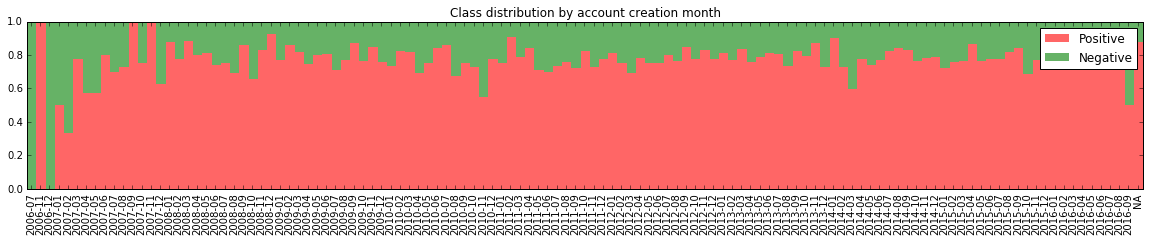

In [11]:
def count_users(grouped):
    """
    Counts number of positive and negative users
    created at each date.
    
    Returns:
        count_pos -- 1D numpy array with the counts of positive users created at each date
        count_neg -- 1D numpy array with the counts of negative users created at each date
        dts -- a list of date strings, e.g. ['2014-10', '2014-11', ...]
    """
    dts = []
    count_pos, count_neg = np.zeros(len(grouped)), np.zeros(len(grouped))
    # your code here 
    index = 0
    for user_group in grouped:
        dts.append(user_group[0])
        for a in user_group[1]["cls"].values:
            if a == 1.0: count_pos[index] += 1
            if a == 0.0: count_neg[index] += 1
        index += 1
    return count_pos, count_neg, dts


grouped = df_full.groupby(map(lambda dt: dt if pd.notnull(dt) else "NA", df_full["created_at"]))
count_pos, count_neg, dts = count_users(grouped)
    
fraction_pos = count_pos / (count_pos + count_neg + 1e-10)
fraction_neg = 1 - fraction_pos

sort_ind = np.argsort(dts)
    
pl.figure(figsize=(20, 3))
pl.bar(np.arange(len(dts)), fraction_pos[sort_ind], width=1.0, color='red', alpha=0.6, linewidth=0, label="Positive")
pl.bar(np.arange(len(dts)), fraction_neg[sort_ind], bottom=fraction_pos[sort_ind], width=1.0, color='green', alpha=0.6, linewidth=0, label="Negative")
pl.xticks(np.arange(len(dts)) + 0.4, sorted(dts), rotation=90)
pl.title("Class distribution by account creation month")
pl.xlim(0, len(dts))
pl.legend()
pl.show()

Видно, что доля "положительных" аккаунтов в выборке растет с увеличением времени. Посмотрим, где живут пользователи положительной и отрицательной категории. Для этого отметим на карте каждого положительного пользователя красным, а отрицательного -- зеленым цветом ([подсказка](http://stroykova.github.io/sphera/l1_2.png)). Необходимо реализовать функцию plot_points_on_map. В функции необходимо отобразить на карте пользователей из разных классов (2 балла).

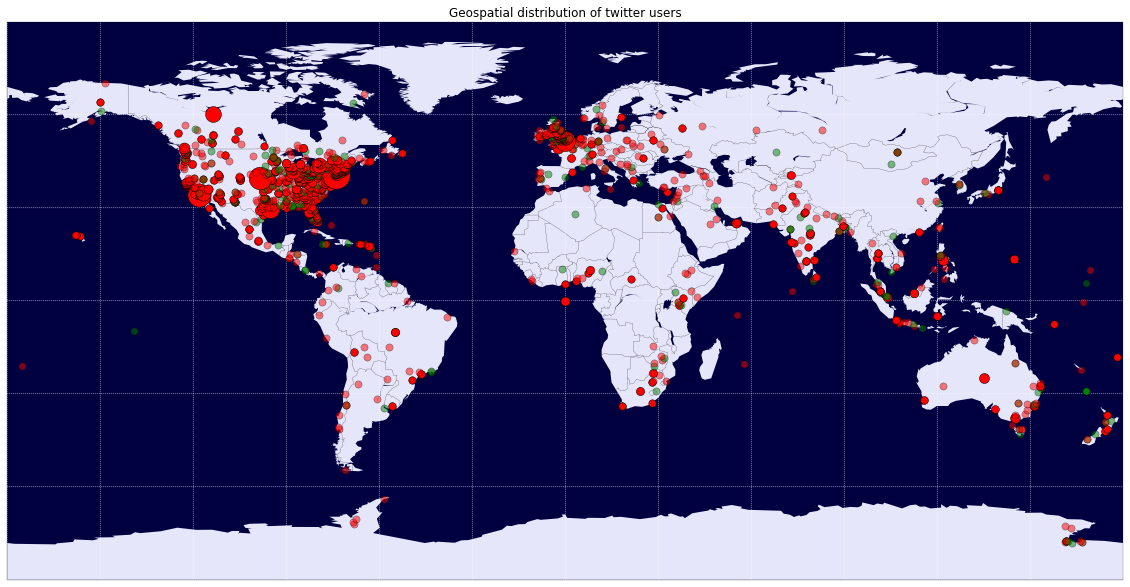

In [13]:
pl.figure(figsize=(20,12))

m = bm.Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180, resolution='c')

m.drawcountries(linewidth=0.2)
m.fillcontinents(color='lavender', lake_color='#000040')
m.drawmapboundary(linewidth=0.2, fill_color='#000040')
m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0], color='white', linewidth=0.5)
m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0], color='white', linewidth=0.5)

def plot_points_on_map(df_full):
    """
    Plot points on the map. Be creative.
    """
    # your code here
    grouped_for_map = df_full.groupby(map(lambda dt: dt, df_full[["lat","lon","cls"]]))
    
    for user_group in grouped_for_map:
        #координаты
        lat = user_group[0][0]
        lon = user_group[0][1]  
        
        red = 0
        green = 0
        
        for a in user_group[1]["cls"].values:
            if a == 1.0: red += 1
        for b in user_group[1]["cls"].values:
            if b == 0.0: green += 1
        
        if green > 0: 
            color = 'go' 
            markersize = 7 + green * 0.2
            transparency = green * 0.5
            if transparency > 1: transparency = 1
            m.plot(lon, lat,  color, alpha = transparency, markersize=markersize)
            
        if red > 0: 
            color = 'ro' 
            markersize = 7 + red * 0.2
            transparency = red * 0.5
            if transparency > 1: transparency = 1
            m.plot(lon, lat,  color,alpha = transparency, markersize=markersize)
            
    return

plot_points_on_map(df_full)

pl.title("Geospatial distribution of twitter users")
pl.legend()
pl.show()

В последней картинке есть проблема: сервис геоинформации определяет координаты с точностью до города, поэтому точки, соответствующте нескольким пользователям, могут накладываться. Предложите и реализуйте способ, позволяющий справиться с этой проблемой (2 балла).


В поле ниже необходимо словами описать, как было улучшено изображение (описание необходимо для корректной проверки задания).

На изображении сделаны следующие улучшения:
* Чем больше людей из нашей выборки живёт в данном городе, тем более ярким цветом помечен кружочек (прозрачность меньше).
* Чем больше людей из нашей выборки живёт в данном городе, тем больше размер кружочка (тем самым можем отличать друг от друга "мегаполисы", где количество пользователей достаточно большое, чтобы яркость была 1.

#### Опредилим пользователи какого класса популярнее, а именно пользователи какого класса имеют больше фолловеров. 

Для этого
    1. Посчитайте дескриптивные статистики для признака followers_count -- min, max, mean и median 
    2. Постройте гистограммы для пользователей двух классов.
[подсказка](http://stroykova.github.io/sphera/l1_3.png) 
    3. На основе полученных данных ответьте на вопросы 
        1. Почему mean и median имеют разные значения?
$ \it Ответ:$ Медиана (median) — это такое число выборки, что ровно половина из элементов выборки больше него, а другая половина меньше него. Среднее (mean) - это такое число, которое является средним арифметическим всей нашей выборки. Несложно заметить по максимальным значениям, что у нас присутствуют выбросы, отличающиеся на несколько порядков от средних значений по всей выборке. Данные значения очень сильно влияют на mean, однако median, в свою очередь, устойчива к выбросам. 
        2. Пользователи какого класса популярнее? Аргументируйте ответ.
$ \it Ответ:$ Можно заметить, что медаины и средние обоих классов не сильно отличаются друг от друга, на всего лишь одной выборке сложно сделать выводы о всей базе. По этому для ответа на вопрос можно попробовать собрать статистические оценки среднего и медианы. (см. далее)

Подсказка: так как пользователей позитивного класса в 3.5 раза больше, чем негативного прежде чем приступать к анализу необходимо случайным образом выбрать по N(N>=500) пользователей негативного и позитивного классов. (1 балл)

For users in NEGATIVE class:
 min = 0; 	 max = 490186; 	 median = 337; 	 mean = 3377;
For users in POSITIVE class:
 min = 1; 	 max = 350446; 	 median = 339; 	 mean = 2824.


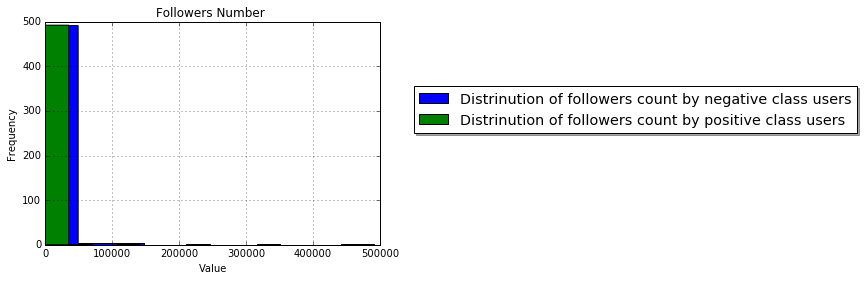

In [18]:
sample_number = 500
users_wth_neg_class = df_full[df_full["cls"]==0].sample(sample_number)
users_wth_pos_class = df_full[df_full["cls"]==1].sample(sample_number)

def descriptive_stat_and_hist(users_wth_neg_class, users_wth_pos_class):
        #Calculate min max and median. Plot histogram
        #Your code here
    print "For users in NEGATIVE class:\n min = %d; \t max = %d; \t median = %d; \t mean = %d;"%(
        users_wth_neg_class['followers_count'].min(),
        users_wth_neg_class['followers_count'].max(),
        users_wth_neg_class['followers_count'].median(),
        users_wth_neg_class['followers_count'].mean())
    print "For users in POSITIVE class:\n min = %d; \t max = %d; \t median = %d; \t mean = %d."%(
        users_wth_pos_class['followers_count'].min(),
        users_wth_pos_class['followers_count'].max(),
        users_wth_pos_class['followers_count'].median(),
        users_wth_pos_class['followers_count'].mean())
    
    users_wth_neg_class['followers_count'].hist(label = "Distrinution of followers count by negative class users")
    users_wth_pos_class['followers_count'].hist(label = "Distrinution of followers count by positive class users")
    pl.xlabel('Value')
    pl.ylabel('Frequency')
    pl.title('Followers Number ')
    pl.legend(loc = (1.1,0.5), shadow=True, fontsize='x-large')
    return
descriptive_stat_and_hist(users_wth_neg_class, users_wth_pos_class)

In [19]:
#Стаистические оценки среднего и медианы

def statistics(df_full,quantity):
    sample_number = 500
    mean_pos = 0.0
    median_pos = 0.0
    mean_neg = 0.0
    median_neg = 0.0
    for i in xrange(quantity):
        users_wth_neg_class = df_full[df_full["cls"]==0].sample(sample_number)
        users_wth_pos_class = df_full[df_full["cls"]==1].sample(sample_number)
        mean_pos += users_wth_pos_class['followers_count'].mean()
        median_pos += users_wth_pos_class['followers_count'].median()
        mean_neg += users_wth_neg_class['followers_count'].mean()
        median_neg += users_wth_neg_class['followers_count'].median()
    return median_pos/quantity, median_neg/quantity, mean_pos/quantity, mean_neg/quantity

print statistics(df_full, 100)
print statistics(df_full, 500)
print statistics(df_full, 1000)
print statistics(df_full, 2000)

(360.11, 374.195, 2752.5863998331274, 2986.764991071279)
(357.297, 372.828, 2741.909330394832, 2972.2755355639215)
(361.031, 372.2225, 2741.9421302102, 2991.1724824239222)
(360.51575, 371.81275, 2744.0161542163155, 3019.705950163295)


$ \it Продолжение$ $ \it ответа:$ Исходя из статичтической выборки можно сделать вывод, что пользователи ${\bf негативного}$ ${\bf класса}$ более популярны, так как значения медианы и среднего у них получаются больше, хоть и не на много.


Смотрим на полученный data frame и сохраняем его в .csv файл.

In [20]:
OUT_FILE_PATH = "hw1_out.csv"
print "Saving output data frame to %s" % OUT_FILE_PATH
df_full.to_csv(OUT_FILE_PATH, sep="\t", index=False, encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC)
df_full.head()

Saving output data frame to hw1_out.csv


,uid,cls,name,screen_name,description,verified,location,lat,lon,country,created_at,followers_count,friends_count,statuses_count,favourites_count,listed_count
0,202388889,1.0,Kim Salter,mustangkim11,Author- Artist-Marvel-Cars-Books-Music,False,"Gulfport, FL",27.74836,-82.70343,United States,2010-10,1052.0,1960.0,9477.0,21301.0,28.0
1,1392518336,0.0,Tomboy Tarts,TomboyTarts,Celebrating the classic tomboy spirit with a b...,False,Singapore/Malaysia,1.54860,103.52690,Malaysia,2013-04,1188.0,835.0,19286.0,7182.0,111.0
2,361208576,1.0,THE MANC GEEK,BigA85GL,"Mancunian geek, blogger/writer/reviewer. Consu...",False,"Manchester, UK",53.48095,-2.23743,United Kingdom,2011-08,634.0,576.0,7844.0,1141.0,28.0
3,1535215357,1.0,L,laurynjiles,I'd rather be in Paris.,False,Marvel. DC.,NaN,NaN,Marvel. DC.,2013-06,2362.0,2434.0,187988.0,87939.0,68.0
4,4396196375,1.0,#1stEdifyToUplift,EdifyToUplift,Awareness.Advocacy.Ascend🎈 •Focused on buildi...,False,God is my refuge; gem❤️,NaN,NaN,God is my refuge; gem❤️,2015-12,1247.0,961.0,36379.0,26724.0,75.0
